### Convert Data Types

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.cluster import KMeans
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('/Users/madanmaskara/Documents/Madan Maskara_CuvetteDS/Madan Maskara_Machine Learning/Madan Maskara Machine Learning/The Datasets.csv')

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Function to clean currency values
def clean_currency(value):
    if isinstance(value, str):
        return float(value.replace('$', '').replace(',', ''))
    elif np.isnan(value):
        return np.nan
    else:
        return float(value)

# Clean numerical columns
numeric_cols = ['Opening Amount', 'Highest Amount', 'Lowest Amount', 'Closing Amount', 'Volume', 'Market Cap']
for col in numeric_cols:
    df[col] = df[col].apply(clean_currency)

# Set Date as index
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

# Display cleaned data
print(df.head())
print(df.info())

            Opening Amount  Highest Amount  Lowest Amount  Closing Amount  \
Date                                                                        
2019-08-01            1.72            1.81           1.71            1.77   
2019-08-02            1.77            1.82           1.77            1.79   
2019-08-03            1.79            1.87           1.78            1.81   
2019-08-04            1.81            1.86           1.73            1.80   
2019-08-05            1.80            1.85           1.75            1.76   

               Volume  Market Cap  
Date                               
2019-08-01  1604662.0         0.0  
2019-08-02  1787778.0         0.0  
2019-08-03  1386970.0         0.0  
2019-08-04  1659265.0         0.0  
2019-08-05  2060357.0         0.0  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1199 entries, 2019-08-01 to 2022-11-11
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  --

### Handle Missing Data

In [2]:
# Check for missing values
print(df.isnull().sum())

# Fill missing values using forward fill for prices and zeros for volume/market cap
df[numeric_cols] = df[numeric_cols].fillna(method='ffill')
df['Volume'] = df['Volume'].fillna(0)
df['Market Cap'] = df['Market Cap'].fillna(0)

# Verify no missing values remain
print(df.isnull().sum())

Opening Amount    0
Highest Amount    0
Lowest Amount     0
Closing Amount    0
Volume            0
Market Cap        0
dtype: int64
Opening Amount    0
Highest Amount    0
Lowest Amount     0
Closing Amount    0
Volume            0
Market Cap        0
dtype: int64


### Outlier Detection

Original shape: (1199, 6)
Cleaned shape: (1107, 6)


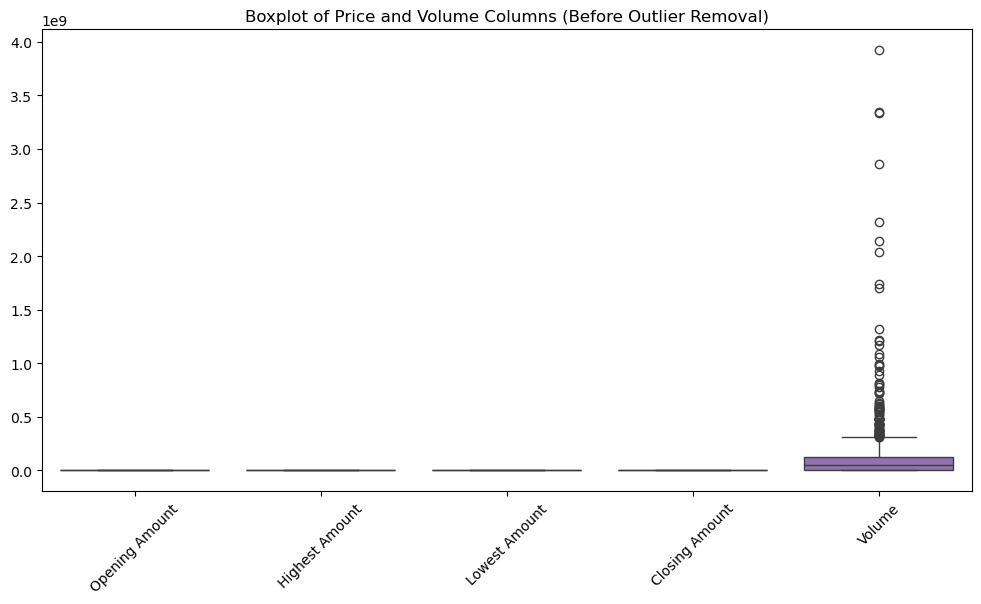

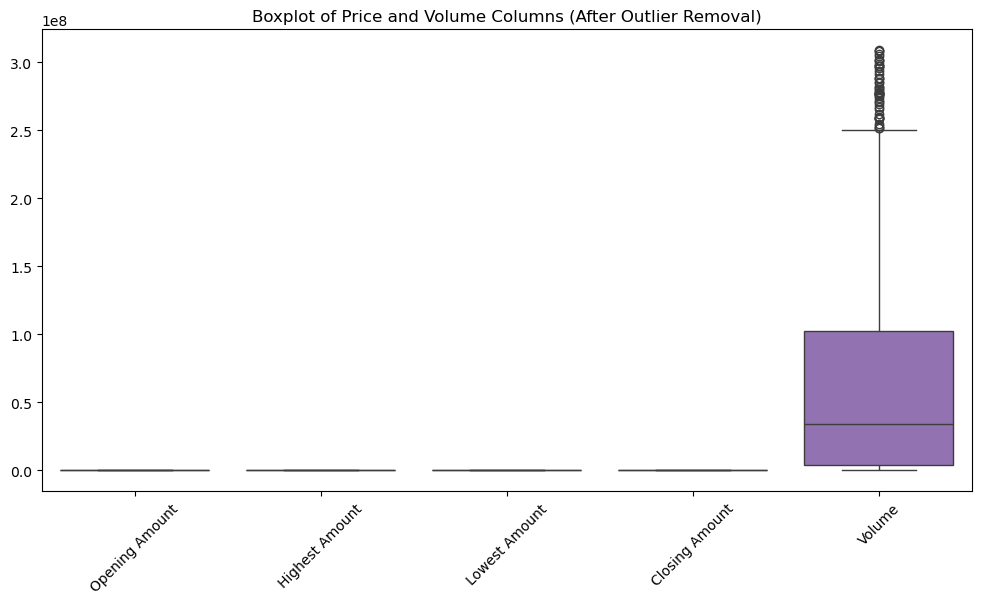

In [3]:
# Function to detect and remove outliers using IQR
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Remove outliers from price and volume columns
price_volume_cols = ['Opening Amount', 'Highest Amount', 'Lowest Amount', 'Closing Amount', 'Volume']
df_clean = remove_outliers(df, price_volume_cols)

# Compare before and after
print(f"Original shape: {df.shape}")
print(f"Cleaned shape: {df_clean.shape}")

# Plot to visualize outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[price_volume_cols])
plt.title('Boxplot of Price and Volume Columns (Before Outlier Removal)')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_clean[price_volume_cols])
plt.title('Boxplot of Price and Volume Columns (After Outlier Removal)')
plt.xticks(rotation=45)
plt.show()

### Normalize Market Cap

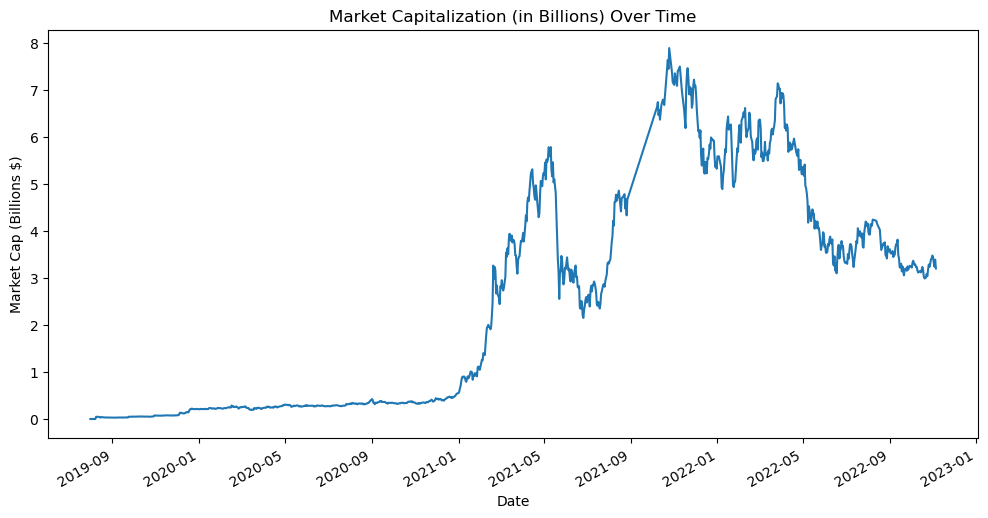

In [4]:
# Normalize Market Cap to billions for better readability
df_clean['Market Cap (Billions)'] = df_clean['Market Cap'] / 1e9

# Plot normalized market cap
plt.figure(figsize=(12, 6))
df_clean['Market Cap (Billions)'].plot()
plt.title('Market Capitalization (in Billions) Over Time')
plt.ylabel('Market Cap (Billions $)')
plt.xlabel('Date')
plt.show()

### Time-Series Analysis
##### Predict Future Prices

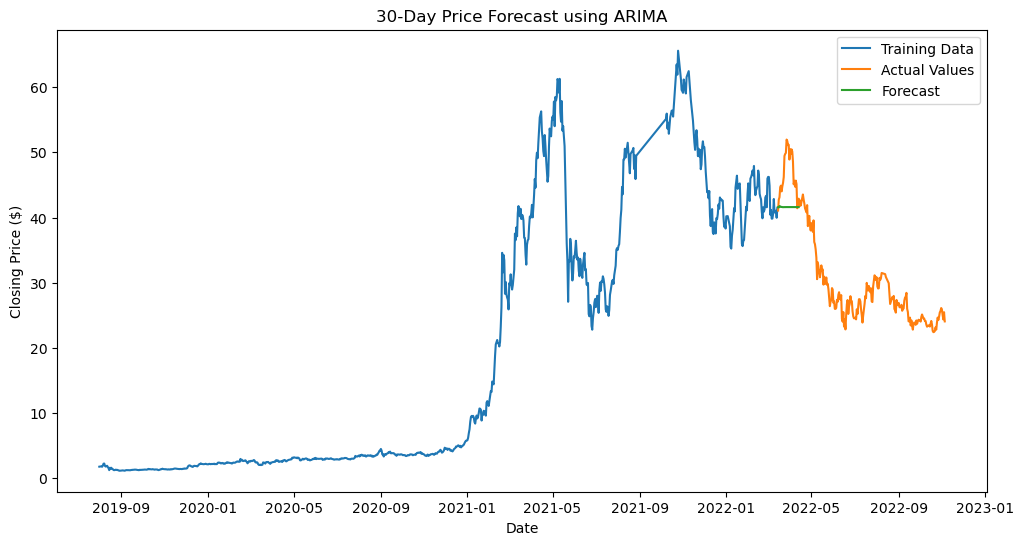

In [5]:
# Prepare data for time series forecasting
ts_data = df_clean[['Closing Amount']].copy()

# Split into train and test sets (last 30 days as test)
train_size = int(len(ts_data) * 0.8)
train, test = ts_data.iloc[:train_size], ts_data.iloc[train_size:]

# Fit ARIMA model
model = ARIMA(train, order=(5,1,0))
model_fit = model.fit()

# Forecast next 30 days
forecast = model_fit.forecast(steps=30)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Values')
plt.plot(pd.date_range(start=test.index[0], periods=30), forecast, label='Forecast')
plt.title('30-Day Price Forecast using ARIMA')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.show()

#### Detect Seasonal Trends

<Figure size 1200x800 with 0 Axes>

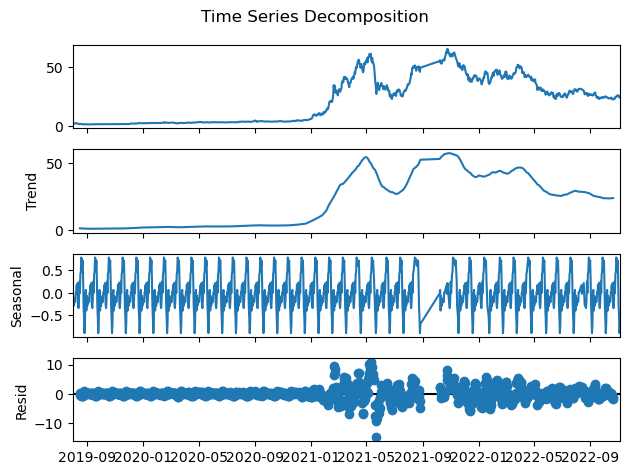

In [6]:
# Decompose time series to observe trends and seasonality
decomposition = seasonal_decompose(ts_data, model='additive', period=30)  # Assuming monthly seasonality

# Plot decomposition
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.suptitle('Time Series Decomposition')
plt.tight_layout()
plt.show()

#### Moving Average Calculation

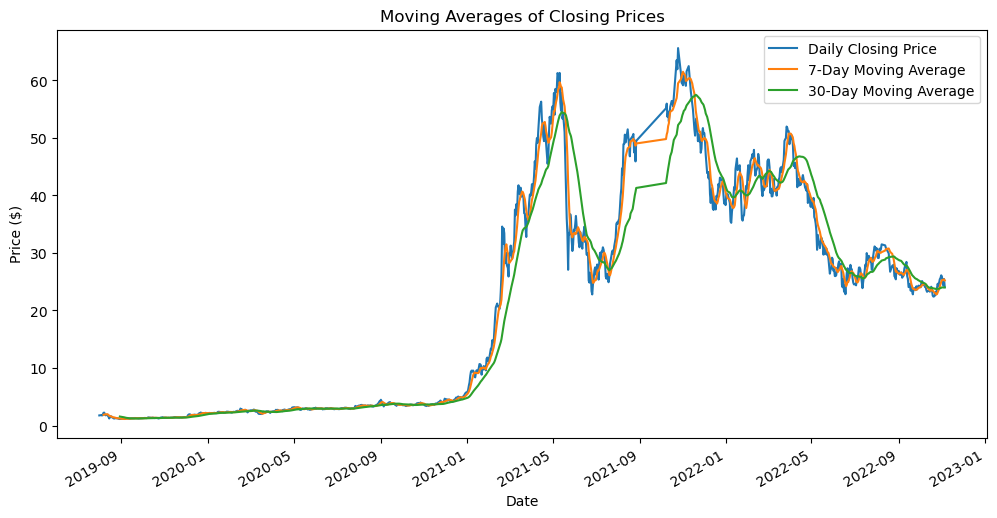

In [7]:
# Calculate moving averages
df_clean['7_day_MA'] = df_clean['Closing Amount'].rolling(window=7).mean()
df_clean['30_day_MA'] = df_clean['Closing Amount'].rolling(window=30).mean()

# Plot moving averages
plt.figure(figsize=(12, 6))
df_clean['Closing Amount'].plot(label='Daily Closing Price')
df_clean['7_day_MA'].plot(label='7-Day Moving Average')
df_clean['30_day_MA'].plot(label='30-Day Moving Average')
plt.title('Moving Averages of Closing Prices')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

### Market Volatility and Performance

#### Stock Volatility Detection

Most volatile months:
Month
2    0.079044
1    0.074984
5    0.072005
8    0.071754
6    0.065413
Name: Daily Volatility, dtype: float64


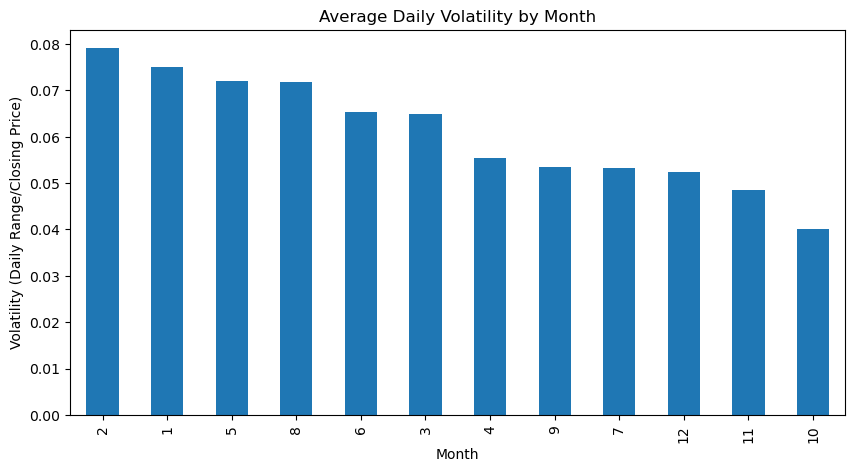

In [8]:
# Calculate daily price range and volatility
df_clean['Daily Range'] = df_clean['Highest Amount'] - df_clean['Lowest Amount']
df_clean['Daily Volatility'] = df_clean['Daily Range'] / df_clean['Closing Amount']

# Find most volatile months
df_clean['Month'] = df_clean.index.month
monthly_volatility = df_clean.groupby('Month')['Daily Volatility'].mean().sort_values(ascending=False)

print("Most volatile months:")
print(monthly_volatility.head())

# Plot monthly volatility
plt.figure(figsize=(10, 5))
monthly_volatility.plot(kind='bar')
plt.title('Average Daily Volatility by Month')
plt.ylabel('Volatility (Daily Range/Closing Price)')
plt.xlabel('Month')
plt.show()

#### Trading Volume Trends

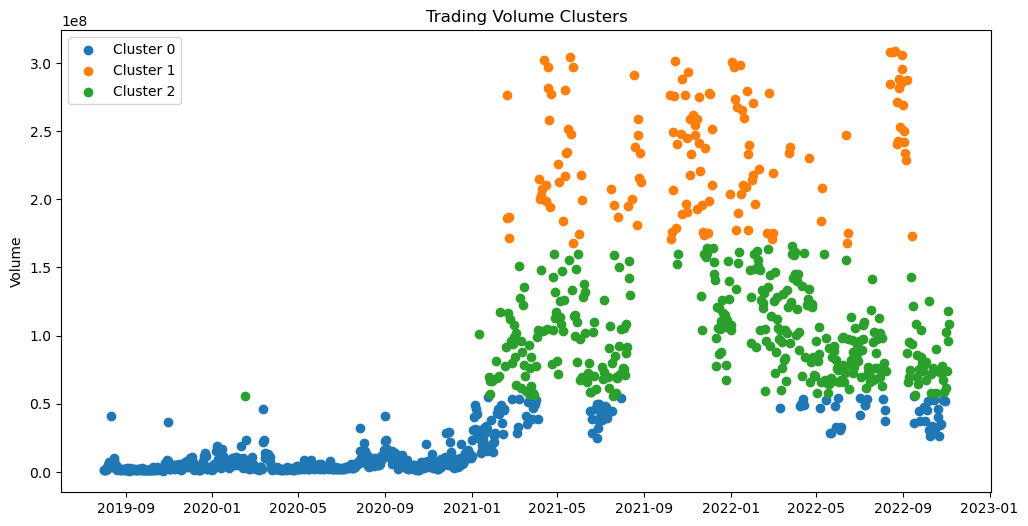

         count          mean           std          min          25%  \
Cluster                                                                
0        629.0  1.161559e+07  1.441682e+07     510850.0    2504937.0   
1        137.0  2.342843e+08  4.118696e+07  167727641.0  199105309.0   
2        341.0  9.955631e+07  2.989913e+07   55616307.0   73869231.0   

                 50%          75%          max  
Cluster                                         
0          5029197.0   11997590.0   55401852.0  
1        234196101.0  271248919.0  308601163.0  
2         95697728.0  120650067.0  165779148.0  


In [9]:
# Cluster days based on trading volume
volume_data = df_clean[['Volume']].copy()

# Normalize volume data
scaler = MinMaxScaler()
volume_data['Volume_scaled'] = scaler.fit_transform(volume_data[['Volume']])

# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
volume_data['Cluster'] = kmeans.fit_predict(volume_data[['Volume_scaled']])

# Plot clusters
plt.figure(figsize=(12, 6))
for cluster in sorted(volume_data['Cluster'].unique()):
    cluster_data = volume_data[volume_data['Cluster'] == cluster]
    plt.scatter(cluster_data.index, cluster_data['Volume'], label=f'Cluster {cluster}')
plt.title('Trading Volume Clusters')
plt.ylabel('Volume')
plt.legend()
plt.show()

# Analyze cluster characteristics
print(volume_data.groupby('Cluster')['Volume'].describe())

#### Identify Price Anomalies

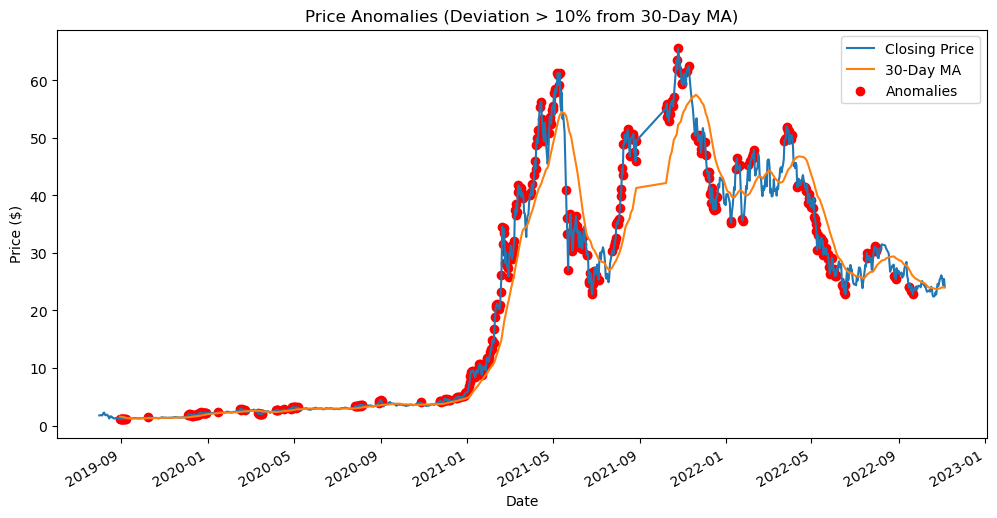

Number of anomalies detected: 411


In [10]:
# Identify days when closing price deviated significantly from 30-day MA
df_clean['Price Deviation'] = (df_clean['Closing Amount'] - df_clean['30_day_MA']) / df_clean['30_day_MA']
df_clean['Anomaly'] = abs(df_clean['Price Deviation']) > 0.1  # 10% deviation threshold

# Plot anomalies
plt.figure(figsize=(12, 6))
df_clean['Closing Amount'].plot(label='Closing Price')
df_clean['30_day_MA'].plot(label='30-Day MA')
anomalies = df_clean[df_clean['Anomaly']]
plt.scatter(anomalies.index, anomalies['Closing Amount'], color='red', label='Anomalies')
plt.title('Price Anomalies (Deviation > 10% from 30-Day MA)')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

print(f"Number of anomalies detected: {len(anomalies)}")

## Model Building

### Stock Price Prediction

Random Forest Model Performance:
RMSE: 7.75
MAE: 6.83


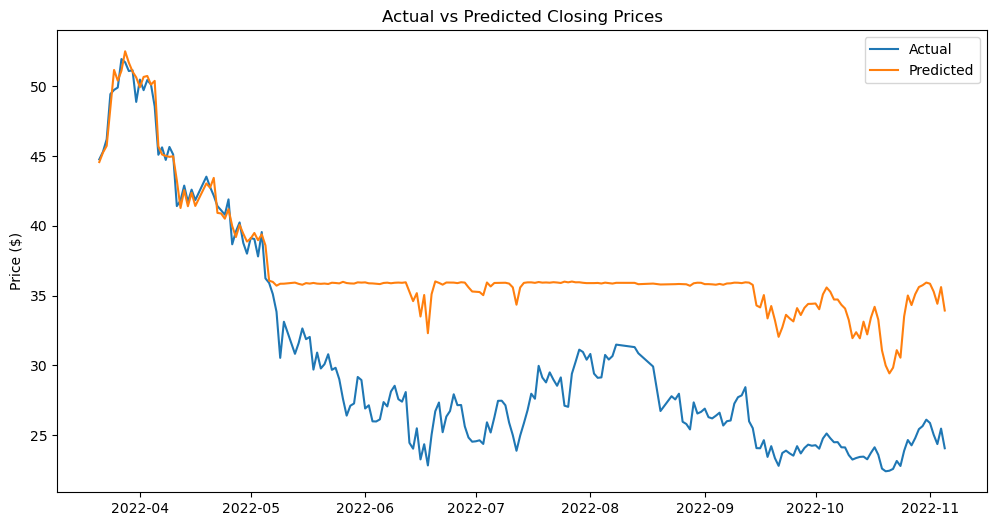

In [11]:
# Prepare features and target for machine learning
def create_features(df, target_col='Closing Amount', lags=5):
    df = df.copy()
    
    # Create lag features
    for lag in range(1, lags+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    
    # Create rolling statistics
    df['rolling_mean_7'] = df[target_col].rolling(window=7).mean()
    df['rolling_std_7'] = df[target_col].rolling(window=7).std()
    
    # Create date features
    df['day_of_week'] = df.index.dayofweek
    df['day_of_month'] = df.index.day
    df['month'] = df.index.month
    
    # Drop rows with NaN values
    df.dropna(inplace=True)
    
    return df

# Create features
ml_data = create_features(df_clean)

# Define features and target
features = [col for col in ml_data.columns if col not in ['Closing Amount', 'Anomaly']]
X = ml_data[features]
y = ml_data['Closing Amount']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate model
y_pred = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Random Forest Model Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.title('Actual vs Predicted Closing Prices')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

### Market Crash Prediction

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       214
           1       0.00      0.00      0.00         2

    accuracy                           0.99       216
   macro avg       0.50      0.50      0.50       216
weighted avg       0.98      0.99      0.99       216

[[214   0]
 [  2   0]]


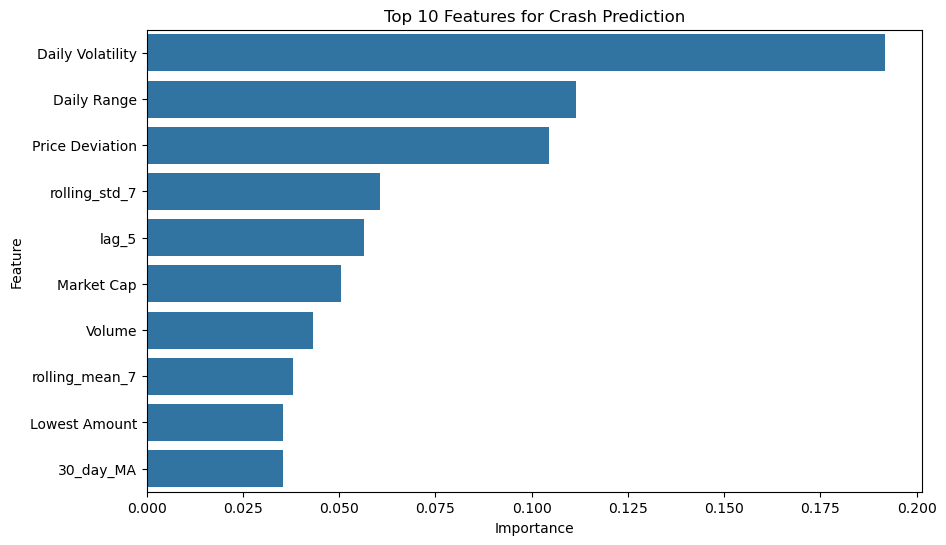

In [12]:
# Create binary target for crashes (price drop > 10% from previous day)
ml_data['Price Change'] = ml_data['Closing Amount'].pct_change()
ml_data['Crash'] = (ml_data['Price Change'] < -0.1).astype(int)

# Create features for classification (using same features as before)
X_class = ml_data[features]
y_class = ml_data['Crash']

# Split data
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class, y_class, test_size=0.2, shuffle=False, stratify=None)

# Train Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_class, y_train_class)

# Evaluate classifier
y_pred_class = rf_classifier.predict(X_test_class)
print(classification_report(y_test_class, y_pred_class))
print(confusion_matrix(y_test_class, y_pred_class))

# Feature importance for crash prediction
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_classifier.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Features for Crash Prediction')
plt.show()

### Feature Importance Analysis

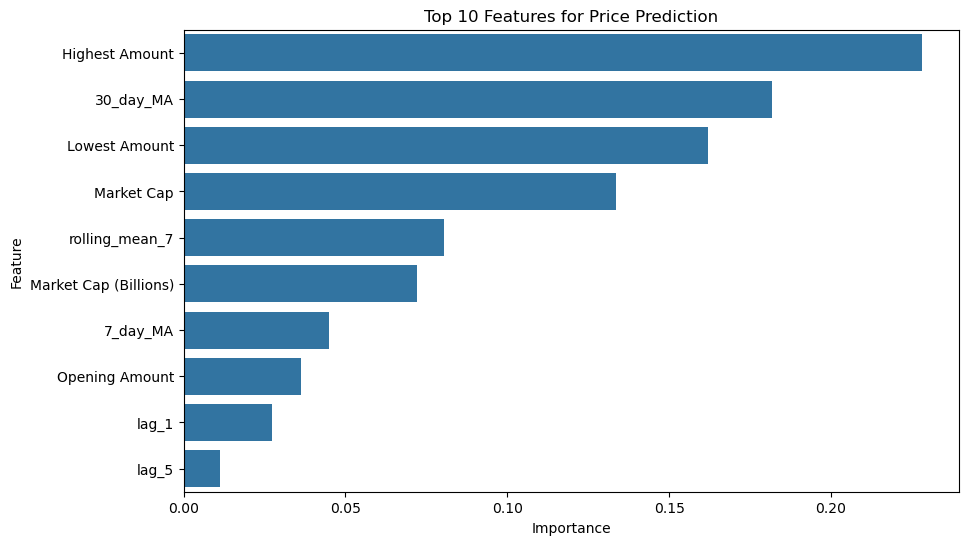

In [13]:
# Feature importance from the Random Forest regression model
feature_importance_reg = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_reg.head(10))
plt.title('Top 10 Features for Price Prediction')
plt.show()

### Predict Trading Volume Spikes

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       192
           1       1.00      1.00      1.00        24

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216

[[192   0]
 [  0  24]]


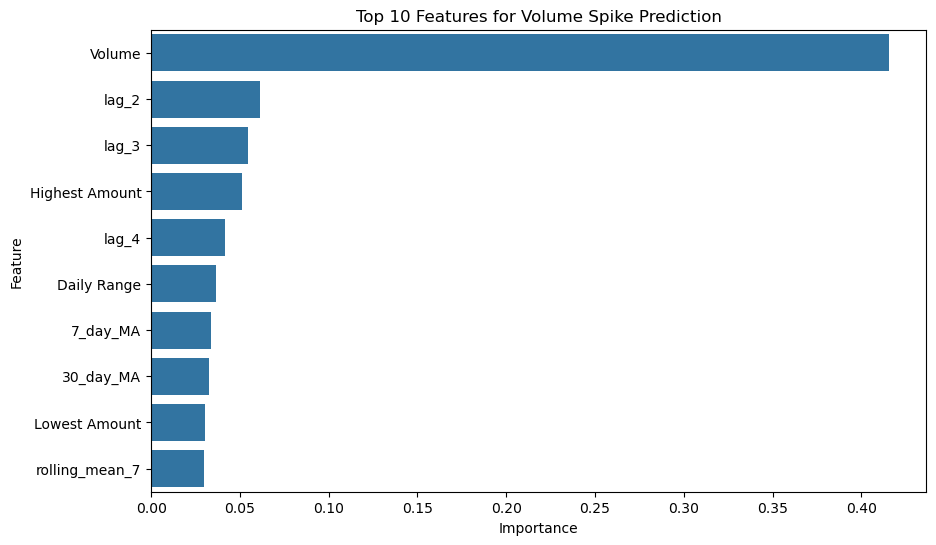

In [14]:
# Create target for volume spikes (volume > 90th percentile)
volume_threshold = ml_data['Volume'].quantile(0.9)
ml_data['Volume Spike'] = (ml_data['Volume'] > volume_threshold).astype(int)

# Create features for volume prediction
X_vol = ml_data[features]
y_vol = ml_data['Volume Spike']

# Split data
X_train_vol, X_test_vol, y_train_vol, y_test_vol = train_test_split(
    X_vol, y_vol, test_size=0.2, shuffle=False, stratify=None)

# Train classifier for volume spikes
vol_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
vol_classifier.fit(X_train_vol, y_train_vol)

# Evaluate classifier
y_pred_vol = vol_classifier.predict(X_test_vol)
print(classification_report(y_test_vol, y_pred_vol))
print(confusion_matrix(y_test_vol, y_pred_vol))

# Feature importance for volume spikes
feature_importance_vol = pd.DataFrame({
    'Feature': features,
    'Importance': vol_classifier.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_vol.head(10))
plt.title('Top 10 Features for Volume Spike Prediction')
plt.show()

### Model Testing and Evaluation

Model Comparison:
                       RMSE       MAE
Linear Regression  0.459956  0.349196
Random Forest      7.754550  6.834242
SVR                8.952190  8.497992
XGBoost            7.314476  6.423065


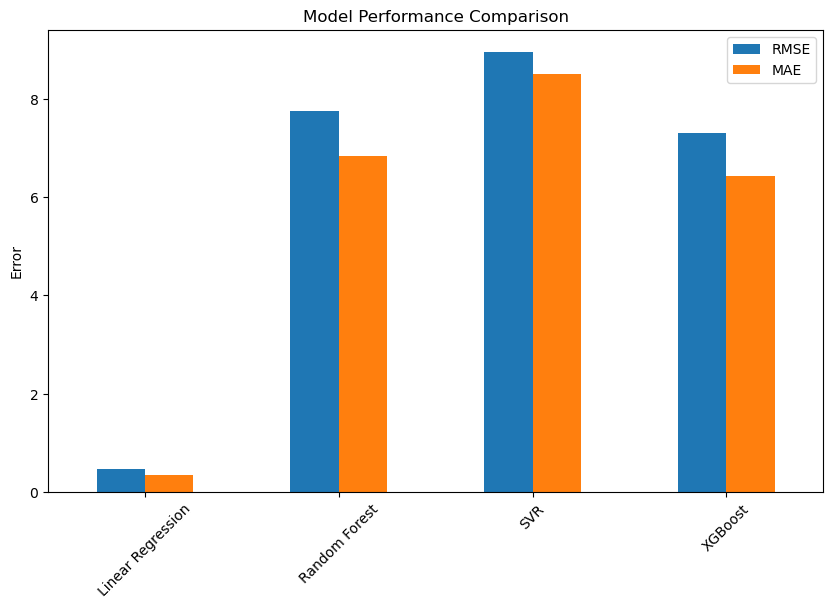

In [15]:
# Compare multiple models for price prediction
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(),
    'XGBoost': XGBRegressor()
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    results[name] = {'RMSE': rmse, 'MAE': mae}

# Display results
results_df = pd.DataFrame(results).T
print("Model Comparison:")
print(results_df)

# Plot model performance
results_df.plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Error')
plt.xticks(rotation=45)
plt.show()

### Cross Validation

In [16]:
# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)
rf_model_cv = RandomForestRegressor(n_estimators=100, random_state=42)

cv_scores = []
for train_index, test_index in tscv.split(X):
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
    
    rf_model_cv.fit(X_train_cv, y_train_cv)
    y_pred_cv = rf_model_cv.predict(X_test_cv)
    rmse = np.sqrt(mean_squared_error(y_test_cv, y_pred_cv))
    cv_scores.append(rmse)

print("Cross-Validation RMSE Scores:", cv_scores)
print(f"Mean CV RMSE: {np.mean(cv_scores):.2f}")

Cross-Validation RMSE Scores: [0.3247914982237614, 6.2687371280071895, 14.321203517726635, 9.023429135234748, 8.470923400695284]
Mean CV RMSE: 7.68


### Hyperparameter Tuning

In [17]:
# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
print(f"Best Model RMSE: {rmse_best:.2f}")

Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}
Best Model RMSE: 7.75


### Compare Model Performance

Final Model Comparison:
                           RMSE       MAE
Linear Regression      0.459956  0.349196
Random Forest (Tuned)  7.757072  6.845794
XGBoost (Tuned)        7.535577  6.553586


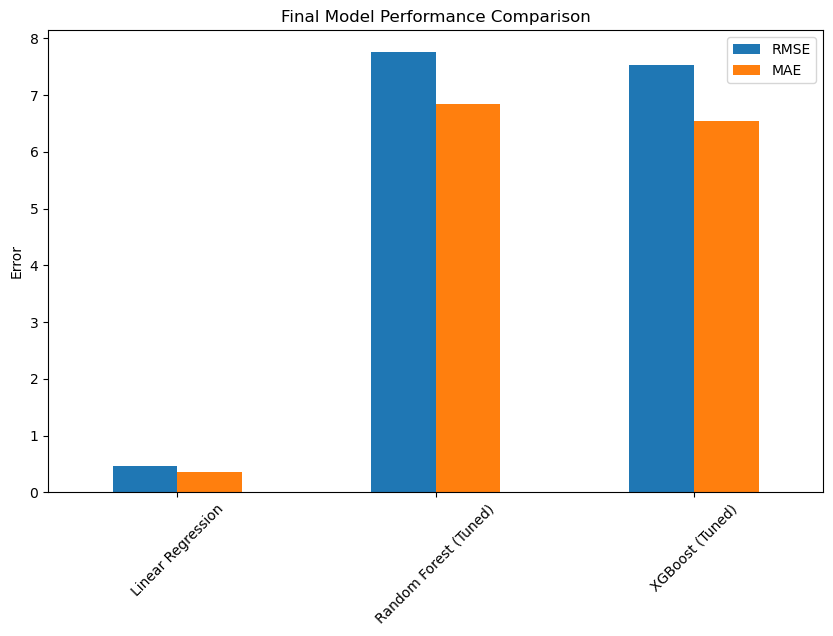

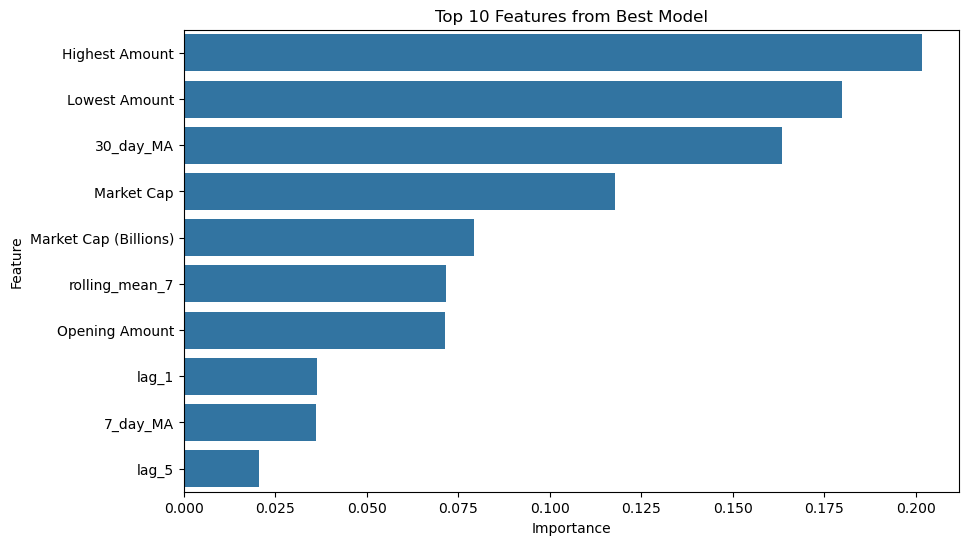

In [20]:
# Compare all models with best parameters
final_models = {
    'Linear Regression': LinearRegression(),
    'Random Forest (Tuned)': RandomForestRegressor(
        n_estimators=200, max_depth=20, min_samples_split=2, random_state=42),
    'XGBoost (Tuned)': XGBRegressor(
        n_estimators=200, max_depth=5, learning_rate=0.1)
}

final_results = {}
for name, model in final_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    final_results[name] = {'RMSE': rmse, 'MAE': mae}

# Display final results
final_results_df = pd.DataFrame(final_results).T
print("Final Model Comparison:")
print(final_results_df)

# Plot final model performance
final_results_df.plot(kind='bar', figsize=(10, 6))
plt.title('Final Model Performance Comparison')
plt.ylabel('Error')
plt.xticks(rotation=45)
plt.show()

# Feature importance from best model
feature_importance_final = pd.DataFrame({
    'Feature': features,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_final.head(10))
plt.title('Top 10 Features from Best Model')
plt.show()

## User Testing 

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings('ignore')

# Load and preprocess data (same as before)
def load_and_preprocess():
    # This would be your actual data loading code
    # For demonstration, I'll create a sample DataFrame
    dates = pd.date_range(start='2022-01-01', end='2022-12-31')
    np.random.seed(42)
    closing_prices = np.cumsum(np.random.randn(len(dates)) * 0.5 + 50)
    volumes = np.random.randint(100000, 1000000, size=len(dates))
    
    df = pd.DataFrame({
        'Date': dates,
        'Closing Amount': closing_prices,
        'Volume': volumes
    }).set_index('Date')
    
    # Create features
    df = create_features(df)
    return df

def create_features(df, target_col='Closing Amount', lags=5):
    df = df.copy()
    
    # Create lag features
    for lag in range(1, lags+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    
    # Create rolling statistics
    df['rolling_mean_7'] = df[target_col].rolling(window=7).mean()
    df['rolling_std_7'] = df[target_col].rolling(window=7).std()
    
    # Create date features
    df['day_of_week'] = df.index.dayofweek
    df['day_of_month'] = df.index.day
    df['month'] = df.index.month
    
    # Drop rows with NaN values
    df.dropna(inplace=True)
    
    return df

# Train models
def train_models(df):
    features = [col for col in df.columns if col not in ['Closing Amount', 'Anomaly', 'Crash', 'Volume Spike']]
    X = df[features]
    y = df['Closing Amount']
    
    # Price prediction model
    price_model = RandomForestRegressor(n_estimators=100, random_state=42)
    price_model.fit(X, y)
    
    # Crash prediction model (price drop > 10%)
    df['Price Change'] = df['Closing Amount'].pct_change()
    df['Crash'] = (df['Price Change'] < -0.1).astype(int)
    X_class = df[features]
    y_class = df['Crash']
    
    crash_model = RandomForestClassifier(n_estimators=100, random_state=42)
    crash_model.fit(X_class, y_class)
    
    # Volume spike model (volume > 90th percentile)
    volume_threshold = df['Volume'].quantile(0.9)
    df['Volume Spike'] = (df['Volume'] > volume_threshold).astype(int)
    X_vol = df[features]
    y_vol = df['Volume Spike']
    
    volume_model = RandomForestClassifier(n_estimators=100, random_state=42)
    volume_model.fit(X_vol, y_vol)
    
    return price_model, crash_model, volume_model, features

# Interactive testing function
def interactive_testing():
    print("Loading and preprocessing data...")
    df = load_and_preprocess()
    print("Training models...")
    price_model, crash_model, volume_model, features = train_models(df)
    
    # Create widgets for user input
    date_input = widgets.DatePicker(
        description='Select Date:',
        value=df.index[-30].to_pydatetime(),  # Default to 30 days before last date
        min=df.index[0].to_pydatetime(),
        max=df.index[-1].to_pydatetime()
    )
    
    analysis_type = widgets.Dropdown(
        options=[
            ('Price Prediction', 'price'),
            ('Crash Probability', 'crash'),
            ('Volume Spike Prediction', 'volume'),
            ('All Analyses', 'all')
        ],
        value='price',
        description='Analysis Type:'
    )
    
    predict_button = widgets.Button(description="Run Analysis")
    output = widgets.Output()
    
    def on_button_click(b):
        with output:
            clear_output()
            selected_date = date_input.value
            selected_date_pd = pd.to_datetime(selected_date)
            
            if selected_date_pd not in df.index:
                print(f"Warning: No data available for {selected_date.strftime('%Y-%m-%d')}")
                print("Showing analysis for nearest available date.")
                selected_date_pd = df.index[df.index.get_loc(selected_date_pd, method='nearest')]
                print(f"Using data from {selected_date_pd.strftime('%Y-%m-%d')}")
            
            # Get the row for the selected date
            row = df.loc[[selected_date_pd], features]
            
            if analysis_type.value == 'price' or analysis_type.value == 'all':
                # Price prediction
                current_price = df.loc[selected_date_pd, 'Closing Amount']
                predicted_price = price_model.predict(row)[0]
                change = (predicted_price - current_price) / current_price * 100
                
                print("\n=== PRICE PREDICTION ===")
                print(f"Current Price: ${current_price:.2f}")
                print(f"Next Day Predicted Price: ${predicted_price:.2f}")
                print(f"Predicted Change: {change:.2f}%")
                
                # Plot recent prices and prediction
                plt.figure(figsize=(10, 5))
                recent_dates = df.index[df.index >= selected_date_pd - timedelta(days=30)]
                plt.plot(recent_dates, df.loc[recent_dates, 'Closing Amount'], label='Historical Prices')
                plt.scatter(selected_date_pd + timedelta(days=1), predicted_price, color='red', label='Predicted Price')
                plt.title('Price Prediction')
                plt.xlabel('Date')
                plt.ylabel('Price ($)')
                plt.legend()
                plt.grid()
                plt.show()
            
            if analysis_type.value == 'crash' or analysis_type.value == 'all':
                # Crash probability
                crash_prob = crash_model.predict_proba(row)[0][1] * 100
                
                print("\n=== CRASH PROBABILITY ===")
                print(f"Probability of price dropping >10% next day: {crash_prob:.1f}%")
                if crash_prob > 30:
                    print("Warning: High crash probability detected!")
                elif crash_prob > 15:
                    print("Caution: Moderate crash probability")
                else:
                    print("Low crash probability")
                
                # Plot crash probability trend
                plt.figure(figsize=(10, 3))
                plt.bar(['Crash Probability'], [crash_prob], color='orange')
                plt.ylim(0, 100)
                plt.title('Crash Probability')
                plt.ylabel('Probability (%)')
                plt.show()
            
            if analysis_type.value == 'volume' or analysis_type.value == 'all':
                # Volume spike prediction
                volume_spike_prob = volume_model.predict_proba(row)[0][1] * 100
                current_volume = df.loc[selected_date_pd, 'Volume']
                
                print("\n=== VOLUME SPIKE PREDICTION ===")
                print(f"Current Volume: {current_volume:,.0f}")
                print(f"Probability of volume spike next day: {volume_spike_prob:.1f}%")
                if volume_spike_prob > 50:
                    print("High likelihood of unusually high trading volume tomorrow")
                else:
                    print("Normal trading volume expected")
                
                # Plot volume trend
                plt.figure(figsize=(10, 5))
                recent_dates = df.index[df.index >= selected_date_pd - timedelta(days=30)]
                plt.plot(recent_dates, df.loc[recent_dates, 'Volume'], label='Historical Volume')
                plt.title('Trading Volume Trend')
                plt.xlabel('Date')
                plt.ylabel('Volume')
                plt.grid()
                plt.show()
    
    predict_button.on_click(on_button_click)
    
    # Display the widgets
    display(widgets.VBox([
        widgets.HBox([date_input, analysis_type]),
        predict_button,
        output
    ]))

# Run the interactive testing
print("FTX Stock Analysis Tool")
print("-----------------------")
interactive_testing()

FTX Stock Analysis Tool
-----------------------
Loading and preprocessing data...
Training models...
